In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml('mnist_784',version = 1)

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X,y = mnist["data"], mnist["target"]

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

In [9]:
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

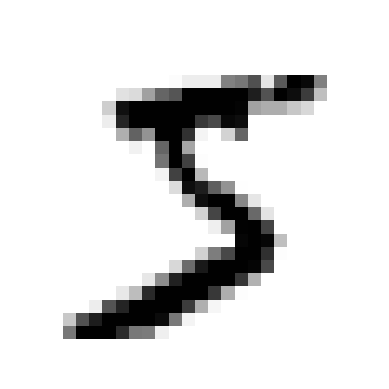

In [10]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")

In [11]:
y[0]

'5'

In [12]:
y = y.astype(np.uint8)

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000], y[60000:]

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

**# Implementing the cross validation**

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [18]:
skfolds = StratifiedKFold(n_splits = 3)

In [19]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_5.iloc[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_5.iloc[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

In [ ]:
from sklearn.base import BaseEstimator

In [ ]:
class Never5Classifier(BaseEstimator):
  def fit(self,X,y = None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype = bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

# Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

For our "5-detector" model, the matrix has four key numbers:

True Positives (TP): Correctly predicted 5s. The model said "5" and the image was indeed a "5". (In the example, this is 3,530.)

False Positives (FP): Incorrectly predicted 5s. The model said "5" but the image was actually a different number. This is also known as a "Type I error." (In the example, this is 687.)

True Negatives (TN): Correctly predicted non-5s. The model said "not a 5" and the image was indeed not a "5". (In the example, this is 53,892.)

False Negatives (FN): Incorrectly predicted non-5s. The model said "not a 5" but the image was actually a "5". This is also known as a "Type II error." (In the example, this is 1,891.)

A perfect classifier would have a confusion matrix with only true positives and true negatives, meaning all the numbers would be on the main diagonal.

# Pretending We reached to perfection

In [ ]:
y_train_perfect_predictions = y_train_5 # pretend that we reached to perfections so that y_perfect = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precision and Recall**
<br>
Scikit-Learn provides several functions to compute classifier metrics,
including precision and recall:

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

It is often convenient to **combine precision and recall into a single metric**
called the **F1 score**, in particular if you need a simple way to compare two
classifiers. The **F1 score** is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the
harmonic mean gives much more weight to low values. As a result, the
classifier will only get a high **F1 score** if both recall and precision are high.


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343847

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

Scikit-Learn does not let you set the threshold directly, but it does give
you access to the decision scores that it uses to make predictions. Instead
of calling the classifier’s predict() method, you can call its
decision_function() method, which returns a score for each instance,
and then use any threshold you want to make predictions based on those
scores:


In [ ]:
threshold = 0 # set threshold value to 0
y_some_digit_pred = (y_scores > threshold) # check if the value is greater than the threshold
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code
returns the same result as the predict() method (i.e., True). Let’s raise
the threshold:


In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

# How to decide the threshold value
1.Get the *cross_val_predict* using the decision method to get the scores of all the instances in the training set

2.Next call *precision_recall_curve* to compute the precision and recall for all the possible thresholds:

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method ="decision_function" )

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the
threshold value

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
  plt.grid(True)
  plt.xlabel("Threshold")
  plt.legend()
  plt.show()

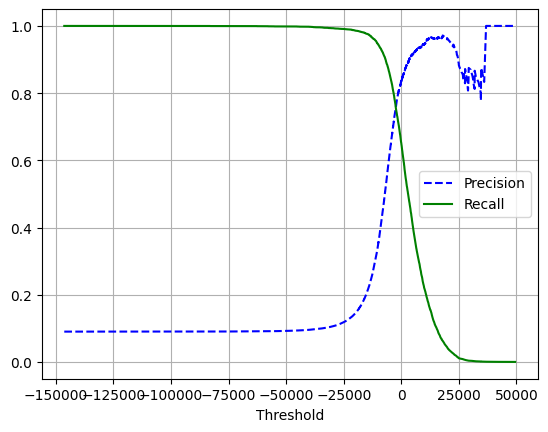

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
